In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model, plot_model
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
print('Tensorflow version =', tf.__version__)

Tensorflow version = 2.0.0-alpha0


## Creating data generators
 - Random rotations applied to augment data

In [2]:
train_data_dir = 'dataset/Training'
validation_data_dir = 'dataset/Validation'
batch_size = 8
img_height, img_width = 100, 100

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(
    img_height, img_width), batch_size=batch_size, class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(
    img_height, img_width), batch_size=batch_size, class_mode='binary')

class_map = train_generator.class_indices

Found 100000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


## Visualizing some images
 - The dataset containes 50000 benign images and 50000 positive cancer images
 - Our task here is to classify a image as 'benign' / 'cancer' given a image

W0406 00:12:07.085622 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:12:07.093526 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:12:07.101020 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:12:07.147429 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:12:07.154478 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:12:07.161497 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:12:07.168482 140617

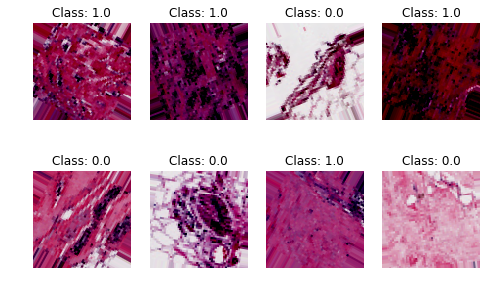

In [3]:
plt.subplots(2, 4, figsize=(8, 5))
disp_images, labels = train_generator.__getitem__(1)
for i, idx in enumerate(disp_images[:8]):
    plt.subplot(2, 4, i+1)
    plt.title(f'Class: {labels[i]}')
    plt.axis('off')
    plt.imshow(disp_images[i])

## Building the model
 - We select the pretrained InceptionV3 model available in keras applications package
 - The last layers is removed and a new fully connected layers is added with units=num_classes (here 2)


In [4]:
base_model = InceptionV3(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False, pooling='avg')
x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, predictions)

## Defining the training and evaluation loops
 - BinaryCrossentropy loss since out lables are binary, using from_logits=True lets the loss function know that the model outputs are not scaled
 - Decorating a python function with tf.function() tell the tensorflow runtime to treat the function as a single computational graph
 - tf.GradientTape() keeps track of variables and actions performed on them under its scope, and thus helps us with differentiation

In [5]:
loss_object = tf.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
train_accuracy = tf.keras.metrics.BinaryAccuracy()
valid_accuracy = tf.keras.metrics.BinaryAccuracy()

def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    return tf.reduce_mean(loss)

def accuracy_function(y_true, y_pred):
    y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), 'int64')
    correct = tf.cast(tf.equal(y_true, y_pred), 'int64')
    correct = tf.reduce_sum(correct)
    return correct / y_true.shape[0]

@tf.function
def training_step(input_tensor, label_tensor):
    with tf.GradientTape() as Tape:
        logits = model(input_tensor, training=True)
        loss = loss_function(label_tensor, logits)
        acc = train_accuracy(label_tensor, logits)
    gradients = Tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc

@tf.function
def evaluation_step(input_tensor, label_tensor):
    with tf.GradientTape() as Tape:
        logits = model(input_tensor)
        acc = valid_accuracy(label_tensor, logits)
    return acc

## Training the model

In [26]:
epochs = 10
loss_array = []
acc_array = []

for epoch in range(epochs):        
    for step in range(train_generator.__len__()):
        img_tensor, label_tensor = train_generator.__getitem__(step)
        label_tensor = tf.reshape(label_tensor, shape=[-1, 1])
        loss, acc = training_step(img_tensor, label_tensor)
        loss_array.append(loss)
        acc_array.append(acc)
        if step % 1000 == 0:
            print(f'| Loss at epoch_{epoch} step_{step} : {loss:.4f} |', f'acc : {acc:.3f} |')
model.save_weights('_model_weights.h5')

| Loss at epoch_0 step_0 : 0.8266 | acc : 0.250 |
| Loss at epoch_0 step_1000 : 0.5613 | acc : 0.739 |
| Loss at epoch_0 step_2000 : 0.7166 | acc : 0.755 |
| Loss at epoch_0 step_3000 : 0.6042 | acc : 0.765 |
| Loss at epoch_0 step_4000 : 0.6130 | acc : 0.765 |
| Loss at epoch_0 step_5000 : 0.6466 | acc : 0.766 |
| Loss at epoch_0 step_6000 : 0.5943 | acc : 0.771 |
| Loss at epoch_0 step_7000 : 0.5806 | acc : 0.775 |
| Loss at epoch_0 step_8000 : 0.6290 | acc : 0.776 |
| Loss at epoch_0 step_9000 : 0.5032 | acc : 0.778 |
| Loss at epoch_0 step_10000 : 0.6756 | acc : 0.779 |
| Loss at epoch_0 step_11000 : 0.6211 | acc : 0.780 |
| Loss at epoch_0 step_12000 : 0.5038 | acc : 0.781 |
| Loss at epoch_1 step_0 : 0.5507 | acc : 0.782 |
| Loss at epoch_1 step_1000 : 0.5055 | acc : 0.782 |
| Loss at epoch_1 step_2000 : 0.6290 | acc : 0.782 |
| Loss at epoch_1 step_3000 : 0.5292 | acc : 0.784 |
| Loss at epoch_1 step_4000 : 0.6576 | acc : 0.787 |
| Loss at epoch_1 step_5000 : 0.7231 | acc : 0.78

In [6]:
model.load_weights('_model_weights.h5')

## Running the evaluation loop

In [7]:
val_acc_array = []
for step in range(validation_generator.__len__()):
    img_tensor, label_tensor = validation_generator.__getitem__(step)
    label_tensor = tf.reshape(label_tensor, shape=[-1, 1])
    acc = evaluation_step(img_tensor, label_tensor)
    val_acc_array.append(acc)
mean_accuracy = np.mean(val_acc_array)
print(f'| Validation accuracy : {mean_accuracy:.3f} |')

| Validation accuracy : 0.893 |


# Inference loop


W0406 00:15:23.548812 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:15:23.603924 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:15:23.666877 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:15:23.719954 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:15:23.774084 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:15:23.828437 140617717126976 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0406 00:15:23.882372 140617

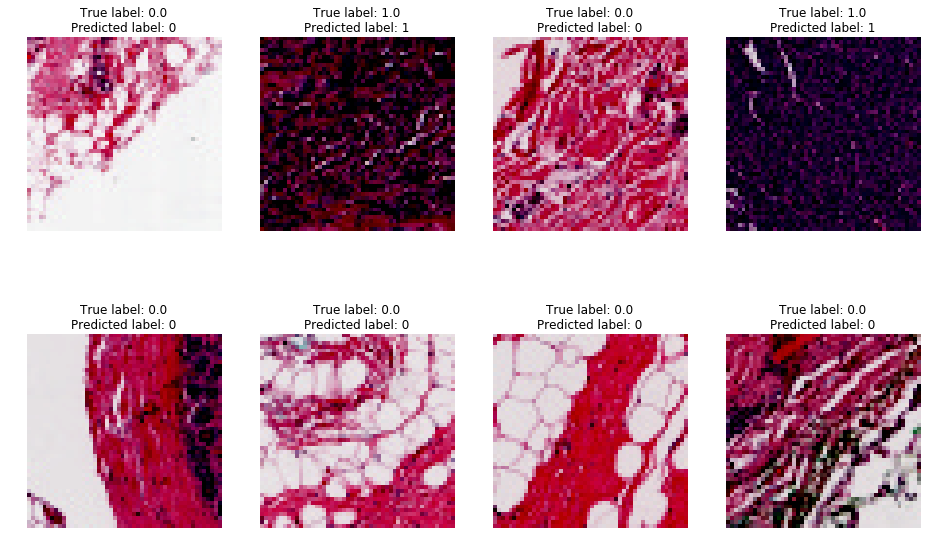

In [10]:
plt.subplots(2, 4, figsize=(16, 10))
test_images, labels = validation_generator.__getitem__(1)
for i, idx in enumerate(test_images[:10]):
    img = test_images[i]
    pred_prob = np.squeeze(model(np.expand_dims(img, axis=0)))
    pred = class_map['1'] if pred_prob >= 0.5 else class_map['0'] 
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(f'True label: {labels[i]}\nPredicted label: {pred}', wrap=True)
    plt.imshow(test_images[i])